In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
import shap
import pickle
import cloudpickle
import numpy as np
from comparers import ModelComparer
from explainers import generate_shap_explanations
from plots import plot_decision_boundary, plot_2d, plot_feature_importance_bar, plot_feature_importance_scatter,\
                  plot_feature_effects, plot_forces
from util import calc_feature_order, calc_class_order, calc_instance_order
import pandas as pd
import diro2c
from data_generation.helper import prepare_df
from data_generation.neighborhood_generation import neighbor_generator
from enums.diff_classifier_method_type import diff_classifier_method_type
from mlxtend.plotting import plot_decision_regions
from sklearn.tree import plot_tree
import rule_extractor
shap.initjs()
%matplotlib inline
task_name = '01'

In [2]:
with open(task_name + '.dataset', 'rb') as f:
    X, display_data, y, feature_names = pickle.load(f)
with open(task_name + '.models', 'rb') as f:
    comparer = pickle.load(f)

# Explain using Interpretability Methods

Prepare dataset for diro2c

In [3]:
idx_explain = 0

In [13]:
y = y.astype(str)
d = dict([(feature_name, feature_data)
          for feature_name, feature_data
          in zip(feature_names, [x for x in X.T])])
d |= {'y': y}
df = pd.DataFrame(d)
dataset = prepare_df(df, 'test', 'y')

## Binary difference explanations

In [48]:
%%time
diff_classifiers_info = diro2c.recognize_diff(idx_explain, X, dataset, comparer.clf_a, comparer.clf_b,
                                              diff_classifier_method_type.binary_diff_classifier,
                                              data_generation_function=neighbor_generator.get_genetic_neighborhood)

CPU times: user 35.4 s, sys: 320 ms, total: 35.7 s
Wall time: 38.1 s


In [49]:
dc_info = diff_classifiers_info['binary_diff_classifer']
dc_full = dc_info['dc_full']
dc_test = dc_info['dc_test']
evaluation_info = dc_info['evaluation_info']

X_diff = evaluation_info['X']
y_diff = evaluation_info['y']

print(np.unique(y_diff, return_counts=True))

(array([0, 1]), array([1764,   10]))


In [50]:
value = 0
width = X.shape[0]
filler_feature_values = {1: value, 3: value, 4: value, 5: value, 6: value, 7: value, 8: value, 9: value, 10: value, 11: value}
filler_feature_ranges = {1: width, 3: width, 4: width, 5: width, 6: width, 7: width, 8: width, 9: width, 10: width, 11: width}

No contour levels were found within the data range.
No contour levels were found within the data range.
Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
No contour levels were found within the data range.


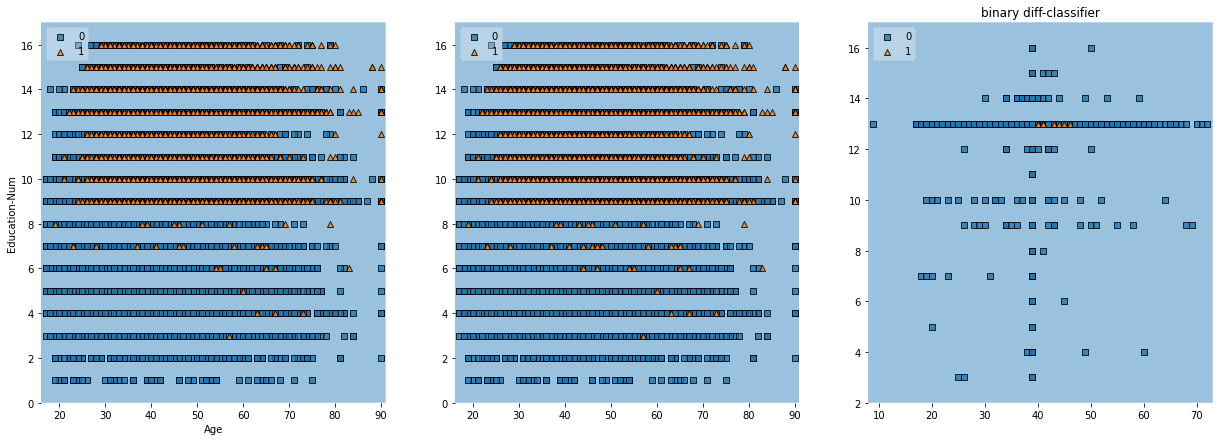

In [51]:
y_pred_a = comparer.clf_a.predict(X)
y_pred_b = comparer.clf_b.predict(X)

fig, ax = plt.subplots(1, 3, figsize=(21, 7))

fig = plot_decision_regions(X=X, y=y_pred_a.astype(np.int64), clf=comparer.clf_a, ax=ax[0], legend=2, feature_index=[0, 2], 
                            filler_feature_values=filler_feature_values, filler_feature_ranges=filler_feature_ranges)
ax[0].set_xlabel(feature_names[0])
ax[0].set_ylabel(feature_names[2])
plt.title('blackbox 1')

fig = plot_decision_regions(X=X, y=y_pred_b.astype(np.int64), clf=comparer.clf_b, ax=ax[1], legend=2, feature_index=[0, 2], 
                            filler_feature_values=filler_feature_values, filler_feature_ranges=filler_feature_ranges)
ax[0].set_xlabel(feature_names[0])
ax[0].set_ylabel(feature_names[2])
plt.title('blackbox 2')

fig = plot_decision_regions(X=X_diff, y=y_diff.astype(np.integer), clf=dc_full, ax=ax[2], legend=2, feature_index=[0, 2], 
                            filler_feature_values=filler_feature_values, filler_feature_ranges=filler_feature_ranges)
ax[0].set_xlabel(feature_names[0])
ax[0].set_ylabel(feature_names[2])
plt.title('binary diff-classifier')

plt.show()

[Text(415.17857142857144, 868.25, 'Age <= 40.5\ngini = 0.02\nsamples = 1712\nvalue = [1695, 17]\nclass = no_diff'),
 Text(199.28571428571428, 792.75, 'Country <= 1.0\ngini = 0.001\nsamples = 1512\nvalue = [1511, 1]\nclass = no_diff'),
 Text(132.85714285714286, 717.25, 'Relationship <= 1.5\ngini = 0.444\nsamples = 3\nvalue = [2, 1]\nclass = no_diff'),
 Text(66.42857142857143, 641.75, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]\nclass = no_diff'),
 Text(199.28571428571428, 641.75, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]\nclass = diff'),
 Text(265.7142857142857, 717.25, 'gini = 0.0\nsamples = 1509\nvalue = [1509, 0]\nclass = no_diff'),
 Text(631.0714285714286, 792.75, 'Age <= 41.5\ngini = 0.147\nsamples = 200\nvalue = [184, 16]\nclass = no_diff'),
 Text(465.0, 717.25, 'Sex <= 0.5\ngini = 0.32\nsamples = 75\nvalue = [60, 15]\nclass = no_diff'),
 Text(332.14285714285717, 641.75, 'Relationship <= 3.5\ngini = 0.444\nsamples = 9\nvalue = [3, 6]\nclass = diff'),
 Text(265.7142857142857, 566.25, '

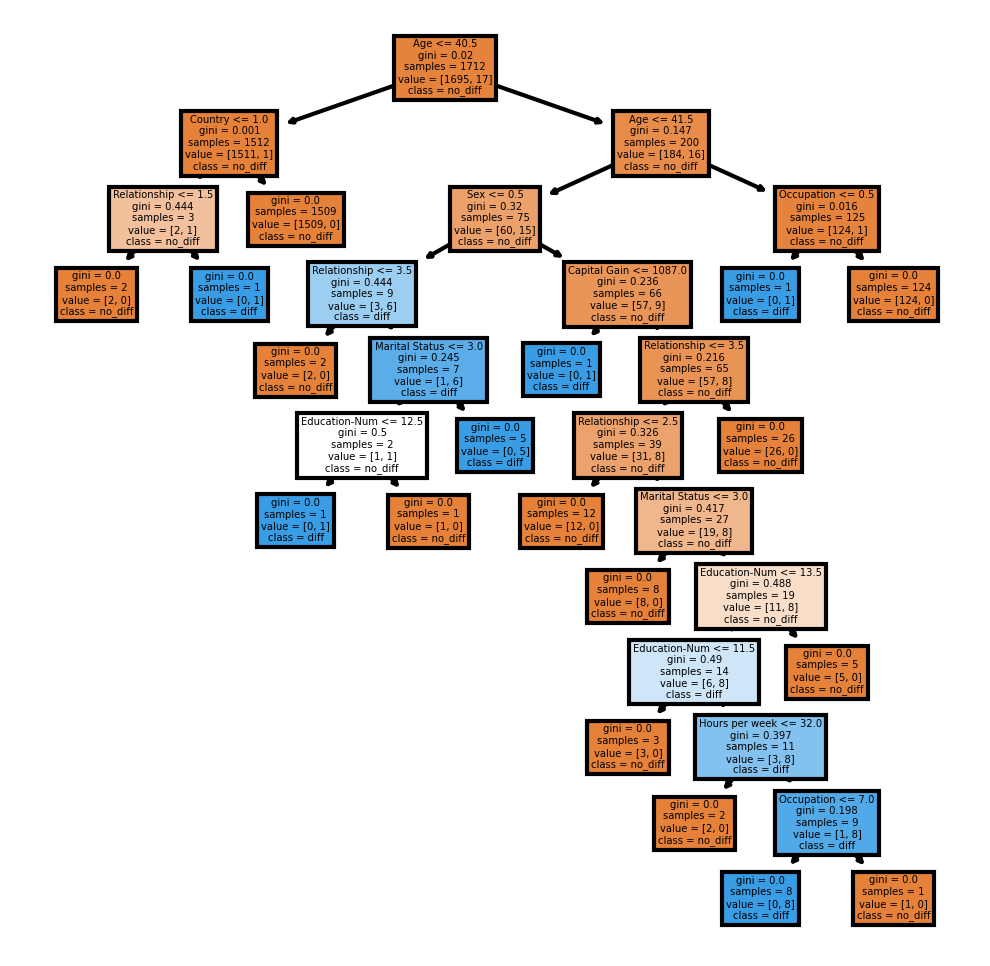

In [23]:
cn = ['no_diff', 'diff']
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), dpi=300)
plot_tree(dc_full,
               feature_names=feature_names,
               class_names=cn,
               filled=True)

In [24]:
rule_extractor.print_rules_for_binary(
    dc_full, dataset['columns_for_decision_rules'], ['no_diff', 'diff'], 'diff')

{'diff': '{Age <= 40.5, Country <= 1.0, Relationship > 1.5}'}
{'diff': '{Age > 40.5, Age <= 41.5, Sex <= 0.5, Relationship > 3.5, Marital Status <= 3.0, Education-Num <= 12.5}'}
{'diff': '{Age > 40.5, Age <= 41.5, Sex <= 0.5, Relationship > 3.5, Marital Status > 3.0}'}
{'diff': '{Age > 40.5, Age <= 41.5, Sex > 0.5, Capital Gain <= 1087.0}'}
{'diff': '{Age > 40.5, Age <= 41.5, Sex > 0.5, Capital Gain > 1087.0, Relationship <= 3.5, Relationship > 2.5, Marital Status > 3.0, Education-Num <= 13.5, Education-Num > 11.5, Hours per week > 32.0, Occupation <= 7.0}'}
{'diff': '{Age > 40.5, Age > 41.5, Occupation <= 0.5}'}


## Multiclass difference explanations

In [40]:
multiclass_diff_names = ['(0, 0)', '(1, 1)', '(1, 0)', '(0, 1)']

In [41]:
%%time
diff_classifiers_info = diro2c.recognize_diff(idx_explain, X, dataset, comparer.clf_a, comparer.clf_b,
                                              diff_classifier_method_type.multiclass_diff_classifier,
                                              data_generation_function=neighbor_generator.get_genetic_neighborhood)

In [42]:
dc_info = diff_classifiers_info['multiclass_diff_classifer']
dc_full = dc_info['dc_full']
dc_test = dc_info['dc_test']
evaluation_info = dc_info['evaluation_info']

X_diff = evaluation_info['X']
y_diff = evaluation_info['y']

print(np.unique(y_diff, return_counts=True))

(array([1, 2, 4]), array([1106,  608,   13]))


No contour levels were found within the data range.
No contour levels were found within the data range.
No contour levels were found within the data range.


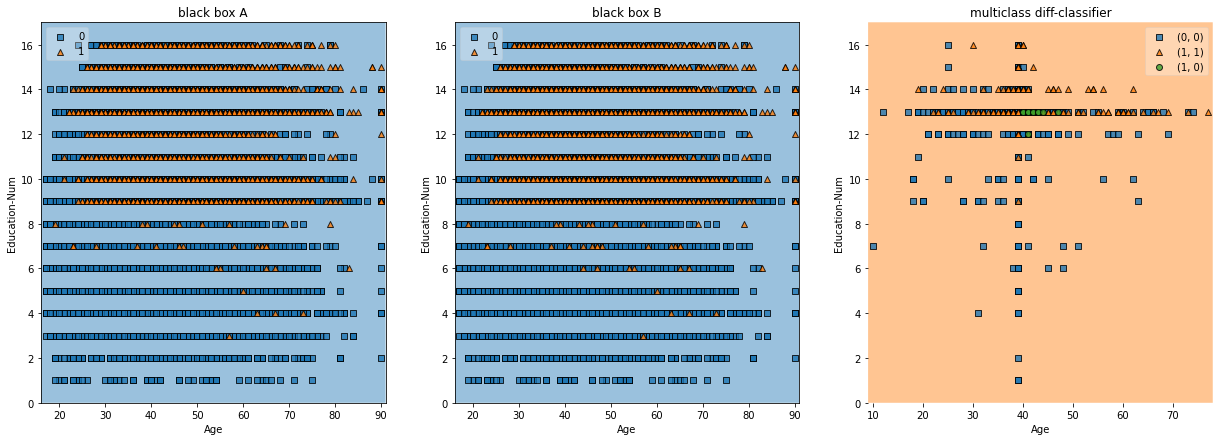

In [46]:
fig, ax = plt.subplots(1, 3, figsize=(21, 7))

fig = plot_decision_regions(X=X, y=y_pred_a.astype(np.int64), clf=comparer.clf_a, ax=ax[0], legend=2,
                            hide_spines=False, feature_index=[0, 2], 
                            filler_feature_values=filler_feature_values, filler_feature_ranges=filler_feature_ranges)
ax[0].set_xlabel(feature_names[0])
ax[0].set_ylabel(feature_names[2])
ax[0].set_title('black box A')

fig = plot_decision_regions(X=X, y=y_pred_b.astype(np.int64), clf=comparer.clf_b, ax=ax[1], legend=2,
                            hide_spines=False, feature_index=[0, 2], 
                            filler_feature_values=filler_feature_values, filler_feature_ranges=filler_feature_ranges)
ax[1].set_xlabel(feature_names[0])
ax[1].set_ylabel(feature_names[2])
ax[1].set_title('black box B')

fig = plot_decision_regions(X=X_diff, y=y_diff.astype(np.int64), clf=dc_full, ax=ax[2], legend=2, feature_index=[0, 2], 
                            filler_feature_values=filler_feature_values, filler_feature_ranges=filler_feature_ranges)
ax[2].set_xlabel(feature_names[0])
ax[2].set_ylabel(feature_names[2])
ax[2].set_title('multiclass diff-classifier')

handles, labels = ax[2].get_legend_handles_labels()
ax[2].legend(handles,
             multiclass_diff_names,
             framealpha=0.3, scatterpoints=1)

plt.show()


[Text(183.89885979729732, 884.4285714285714, 'Relationship <= 2.5\ngini = 0.466\nsamples = 1727\nvalue = [1106, 608, 13]\nclass = (0, 0)'),
 Text(50.270270270270274, 841.2857142857142, 'Capital Gain <= 7124.5\ngini = 0.004\nsamples = 932\nvalue = [930, 2, 0]\nclass = (0, 0)'),
 Text(25.135135135135137, 798.1428571428571, 'Capital Gain <= 5031.5\ngini = 0.002\nsamples = 930\nvalue = [929, 1, 0]\nclass = (0, 0)'),
 Text(12.567567567567568, 755.0, 'gini = 0.0\nsamples = 924\nvalue = [924, 0, 0]\nclass = (0, 0)'),
 Text(37.70270270270271, 755.0, 'Capital Gain <= 5109.5\ngini = 0.278\nsamples = 6\nvalue = [5, 1, 0]\nclass = (0, 0)'),
 Text(25.135135135135137, 711.8571428571429, 'gini = 0.0\nsamples = 1\nvalue = [0, 1, 0]\nclass = (1, 1)'),
 Text(50.270270270270274, 711.8571428571429, 'gini = 0.0\nsamples = 5\nvalue = [5, 0, 0]\nclass = (0, 0)'),
 Text(75.40540540540542, 798.1428571428571, 'Education-Num <= 13.0\ngini = 0.5\nsamples = 2\nvalue = [1, 1, 0]\nclass = (0, 0)'),
 Text(62.83783783

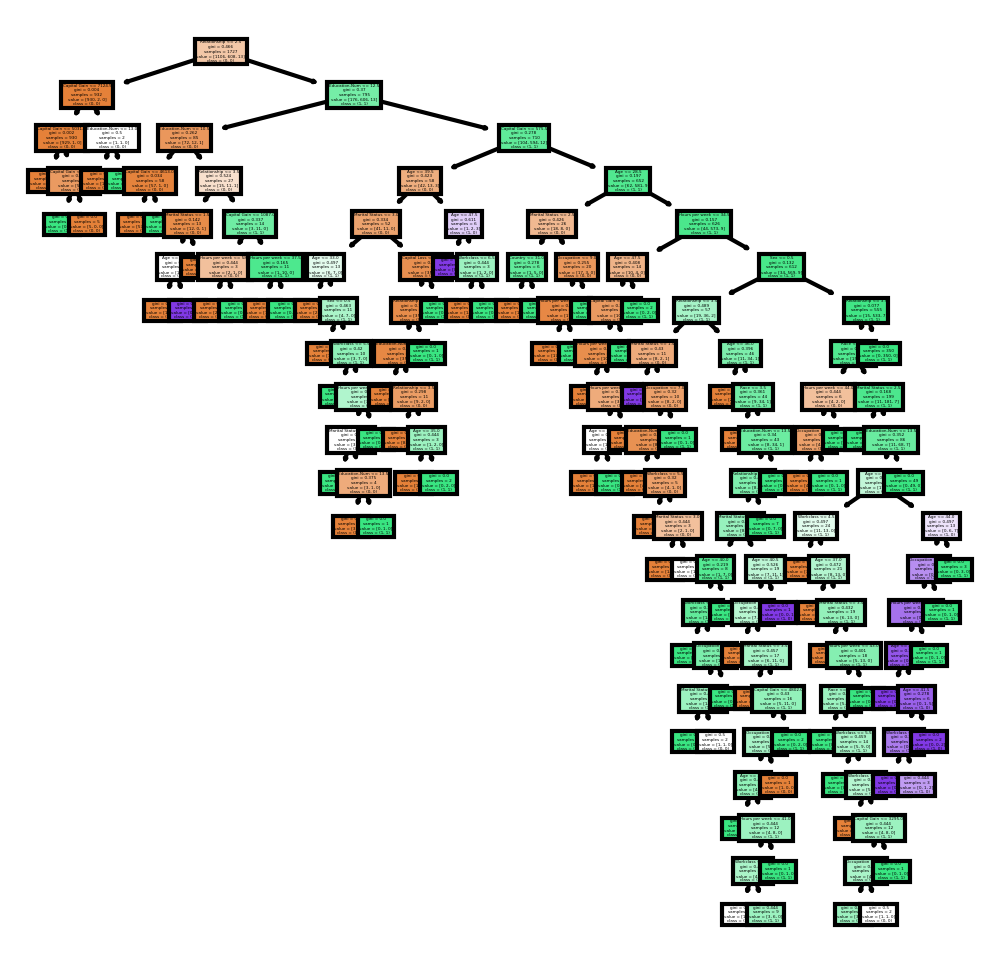

In [47]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), dpi=300)
plot_tree(dc_full,
               feature_names=feature_names,
               class_names=multiclass_diff_names,
               filled=True)